### Objective - Apply SVM on Amazon reviews data set.

In [49]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from prettytable import PrettyTable
from sklearn import svm
from sklearn import linear_model
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

import warnings
warnings.filterwarnings("ignore")

#### Loading the data

In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect("/Users/mohdsaquib/Downloads/database.sqlite") 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be 0 and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [3]:
print(filtered_data.shape) 
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#### Data Cleaning

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#Deduplication of entries
final = sorted_data.drop_duplicates(subset = {"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [5]:
### only  taking those data where HelpfulnessNumerator is less than HelpfulnessDenominator
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

#### Data Preprocessing : Stemming, stop-word removal and Lemmatization.

In [6]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [7]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'what', 'on', 'themselves', 'below', 'o', 'does', 'or', 'who', 'of', 'it', 'from', 'at', "mustn't", 'wouldn', 'be', 'myself', 't', 'their', 'such', 'while', 'itself', 'this', 'was', 'if', "couldn't", 'how', "you'd", 'most', 'yourself', 'she', 'has', 'the', 'hers', 'to', 'these', 'before', "hasn't", 'we', 'your', 'haven', 'above', 'shan', 'do', 'down', 'couldn', 'in', 'why', 'again', 'about', 'been', 'a', 'don', 'over', 'when', 'my', "needn't", 'theirs', 'won', 's', 'each', 'yourselves', 'isn', "haven't", 'have', 'ma', 'those', 'few', "wasn't", 'mustn', 'being', 'between', 'its', 'm', 'ain', 'as', 'wasn', 'both', "she's", 'any', 'further', 'didn', 'than', "should've", 'you', 'which', 'should', "mightn't", 'through', 'doesn', 'with', 'that', 'did', 'against', 'more', 'ours', 'am', 'out', 'herself', "hadn't", 'our', 'yours', 'up', 'needn', "shan't", 'during', 'd', 'hasn', 'very', "you're", 'same', 'just', 'he', 'other', 'there', 'not', 'an', "it's", "aren't", 'into', 'is', 'shouldn', 'y'

In [8]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 1: 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 0:
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [9]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 


In [10]:
# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [11]:
con = sqlite3.connect("final.sqlite")
cleaned_data = pd.read_sql_query("select * from Reviews", con)

In [12]:
print(cleaned_data.shape)
cleaned_data.head()

(364171, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


#### Random sample


In [13]:
# To randomly sample 100k points from both class
random_sample_data = final.sample(n=100000) 
random_sample_data.shape

(100000, 11)

#### Splitting data into test and train

In [14]:
# Sort data based on time
final_sorted_time=random_sample_data.sort_values('Time',ascending=True,axis=0)

In [15]:
final_sorted_time.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,1,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,b'one movi movi collect fill comedi action wha...
346054,374358,B00004CI84,A1HWMNSQF14MP8,will@socialaw.com,1,2,1,978134400,A Afterlife Success,"Many movies, have dealt with the figure of dea...",b'mani movi dealt figur death dead good angel ...
138682,150500,0006641040,A1IJKK6Q1GTEAY,A Customer,2,2,1,1009324800,It Was a favorite!,This was a favorite book of mine when I was a ...,b'favorit book mine littl girl would read time...


In [45]:
 #data splitting
Y_Train=final_sorted_time['Score'][0:70000]
Y_train=final_sorted_time['Score'][0:49000]
Y_cv=final_sorted_time['Score'][49000:70000]
Y_test=final_sorted_time['Score'][70000:100000]

In [46]:
Train_data=final_sorted_time['CleanedText'][0:70000]
X_train=final_sorted_time['CleanedText'][0:49000]
cv_data=final_sorted_time['CleanedText'][49000:70000]
X_test=final_sorted_time['CleanedText'][70000:100000]

#### Featurization

#### Bag of Words

In [18]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_train_counts = count_vect.transform(X_train)
final_test_counts = count_vect.transform(X_test)
print("the type of count vectorizer ",type(final_train_counts))
print("the shape of out text BOW vectorizer ",final_train_counts.get_shape())
print("the number of unique words ", final_train_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaaaahhh', 'aaaaaahhhh', 'aaaaah', 'aaaaahhhhhhhhhhhhhhhh', 'aaah', 'aaahhhhhh', 'aachen', 'aad']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (49000, 26963)
the number of unique words  26963


In [19]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,1), min_df=10, max_features=5000)
final_train_bigram_counts = count_vect.fit_transform(X_train)
final_test_bigram_counts = count_vect.transform(X_test)
print("the type of count vectorizer ",type(final_train_bigram_counts))
print("the shape of out text BOW vectorizer ",final_train_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_train_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (49000, 5000)
the number of unique words including both unigrams and bigrams  5000


#### TF-IDF

In [20]:
tf_idf_vect  = TfidfVectorizer(ngram_range=(1,1),min_df=10)
tf_idf_vect.fit(X_train)
final_train_tf_idf = tf_idf_vect.transform(X_train)
final_test_tf_idf = tf_idf_vect.transform(X_test)
tf_cv  = tf_idf_vect.transform(cv_data)

#### Word2Vec

In [21]:
# Train your own Word2Vec model using your train text corpus
list_of_sent_train = []
for i in X_train:
    sent = []
    for word in i.split():
        sent.append(word.decode('utf-8'))
    list_of_sent_train.append(sent)


In [22]:
list_of_sent_cv = []
for i in cv_data:
    sent = []
    for word in i.split():
        sent.append(word.decode('utf-8'))
    list_of_sent_cv.append(sent)

In [23]:
# List of sentence in X_test text
list_of_sent_test = []
for i in X_test:
    sent = []
    for word in i.split():
        sent.append(word.decode('utf-8'))
    list_of_sent_test.append(sent)



In [24]:
from gensim.models import Word2Vec
w2v_model = Word2Vec(list_of_sent_train,min_count = 5,size = 50,workers = 4)

In [25]:

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  9326
sample words  ['one', 'movi', 'collect', 'fill', 'comedi', 'action', 'whatev', 'els', 'want', 'call', 'mani', 'dealt', 'figur', 'death', 'dead', 'good', 'angel', 'wonder', 'life', 'turn', 'joe', 'black', 'howev', 'tim', 'burton', 'present', 'world', 'look', 'beetlejuic', 'first', 'moment', 'barbara', 'adam', 'maitland', 'town', 'die', 'possibl', 'way', 'return', 'thier', 'hous', 'find', 'selv', 'confin', 'leav', 'send', 'strang', 'desert', 'popul', 'eventu']


#### AVG Word2Vec

In [26]:
sent_vectors_train = []
for sent in list_of_sent_train:
    sent_vec = np.zeros(50)
    cnt_word = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_word += 1
        except:
            pass
    if cnt_word!=0:
        sent_vec /= cnt_word
    
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))

49000


In [27]:
sent_vectors_cv = []
for sent in list_of_sent_cv:
    sent_vec = np.zeros(50)
    cnt_word = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_word += 1
        except:
            pass
    if cnt_word!=0:
        sent_vec /= cnt_word
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))

21000


In [28]:
sent_vectors_test = []
for sent in list_of_sent_test:
    sent_vec = np.zeros(50)
    cnt_word = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_word += 1
        except:
            pass
    if cnt_word!=0:
        sent_vec /= cnt_word
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))

30000


#### TFIDF weighted W2V

In [29]:

tf_idf_feat = tf_idf_vect.get_feature_names()
tfidf_sent_vec_train = []
row = 0
for sent in list_of_sent_train:
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tf_train[row,tf_idf_feat.index(word)]
            sent_vec += (vec*tfidf)
            weight_sum += tfidf
        except:
            pass
    if weight_sum !=0:
        sent_vec/= weight_sum
    
    tfidf_sent_vec_train.append(sent_vec)
    row += 1

In [32]:

tf_idf_feat = tf_idf_vect.get_feature_names()
tfidf_sent_vec_cv = []
row = 0
for sent in list_of_sent_cv:
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tf_cv[row,tf_idf_feat.index(word)]
            sent_vec += (vec*tfidf)
            weight_sum += tfidf
        except:
            pass
    if weight_sum !=0:
        sent_vec/= weight_sum
    tfidf_sent_vec_cv.append(sent_vec)
    row += 1

In [33]:
tf_idf_feat = tf_idf_vect.get_feature_names()
tfidf_sent_vec_test = []
row = 0
for sent in list_of_sent_test:
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tf_test[row,tf_idf_feat.index(word)]
            sent_vec += (vec*tfidf)
            weight_sum += tfidf
        except:
            pass
    if weight_sum !=0:
        sent_vec/= weight_sum
    tfidf_sent_vec_test.append(sent_vec)
    row += 1

In [34]:
tfw2v_train= np.array(tfidf_sent_vec_train)
tfw2v_train.shape

(49000, 50)

In [35]:
tfw2v_cv= np.array(tfidf_sent_vec_cv)

In [36]:
tfw2v_cv.shape

(21000, 50)

In [37]:
tfw2v_test= np.array(tfidf_sent_vec_test)
tfw2v_test.shape

(30000, 50)

In [38]:
np.save("tfw2v_train", tfw2v_train)
np.save("tfw2v_cv", tfw2v_cv)
np.save("tfw2v_test", tfw2v_test)

In [39]:
from prettytable import PrettyTable
x = PrettyTable(["Vectorizer", "Model", "Hyper-parameter","F1 Score", "ROC_AUC"])

### Linear SVM 

#### Linear SVM on BagofWords using SGDClassifier

In [47]:
# Linear kernel using SGDClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, auc
from sklearn.model_selection import TimeSeriesSplit

clf = SGDClassifier(loss='hinge',penalty='l2',max_iter=1000, tol=1e-3, class_weight='balanced',random_state=0)
tscv = TimeSeriesSplit(n_splits=5)
clf_svm = CalibratedClassifierCV(base_estimator=clf, cv=tscv, method='sigmoid')
clf_svm.fit(final_train_bigram_counts, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=0, shuffle=True,
       tol=0.001, verbose=0, warm_start=False),
            cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
            method='sigmoid')

	Precision: 0.889
	Recall: 0.984
	F1: 0.934
	ROC_AUC: 0.704


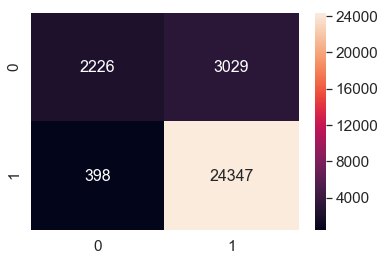

In [48]:
from sklearn.metrics import precision_score, recall_score,f1_score,roc_auc_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

y_pred = clf_svm.predict(final_test_bigram_counts)
print("\tPrecision: %1.3f" % precision_score(Y_test, y_pred))
print("\tRecall: %1.3f" % recall_score(Y_test, y_pred))
print("\tF1: %1.3f" % f1_score(Y_test, y_pred))
print("\tROC_AUC: %1.3f" % roc_auc_score(Y_test, y_pred))
df_cm = pd.DataFrame(confusion_matrix(Y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

#### Linear SVM on BagofWords using LinearSVC

In [50]:
# Linear kernel using LinearSVC
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.model_selection import GridSearchCV
parameters = {'C':[0.1, 1, 10]}
tscv = TimeSeriesSplit(n_splits=5)
lsvc = LinearSVC(penalty='l2',class_weight='balanced',dual=False)
clf_gs = GridSearchCV(lsvc, parameters, cv=tscv,scoring='roc_auc', n_jobs=-1)

LinearSVC(C=0.1, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
	Precision: 0.957
	Recall: 0.890
	F1: 0.922
	ROC_AUC: 0.850


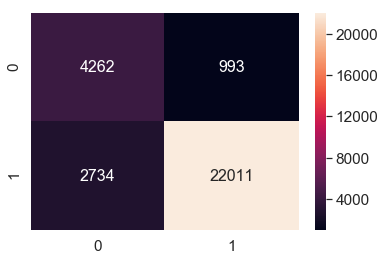

In [51]:
clf_gs.fit(final_train_bigram_counts, Y_train)
print(clf_gs.best_estimator_)
y_pred = clf_gs.best_estimator_.predict(final_test_bigram_counts)
print("\tPrecision: %1.3f" % precision_score(Y_test, y_pred))
print("\tRecall: %1.3f" % recall_score(Y_test, y_pred))
print("\tF1: %1.3f" % f1_score(Y_test, y_pred))
print("\tROC_AUC: %1.3f" % roc_auc_score(Y_test, y_pred))
df_cm = pd.DataFrame(confusion_matrix(Y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g');

x.add_row(["BoW", "Linear kernel using LinearSVC",clf_gs.best_params_, f1_score(Y_test, y_pred), roc_auc_score(Y_test, y_pred)])

In [52]:
# Get the features of Bi-Grams BoW
feat = count_vect.get_feature_names()

#### Top 10 positive and negative features

In [53]:
# Print the best feature for each of the positive and negative classes

n=10
coefs = sorted(zip(clf_gs.best_estimator_.coef_[0], feat))
top = zip(coefs[:n], coefs[:-(n + 1):-1])
print("\t\t\tNegative\t\t\t\t\tPositive")
for (coef1, feat1), (coef2, feat2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef1, feat1, coef2, feat2))

			Negative					Positive
	-1.1803	worst          				1.0781	recycl         
	-0.9325	saucepan       				0.9804	freight        
	-0.8683	terribl        				0.9363	skeptic        
	-0.8602	perfum         				0.8405	necessarili    
	-0.8374	glutino        				0.7993	negat          
	-0.8342	undrink        				0.7513	convinc        
	-0.8113	mid            				0.7455	beetlejuic     
	-0.7823	laden          				0.7442	downsid        
	-0.7706	excus          				0.7400	arabica        
	-0.7694	tasteless      				0.7343	profession     


#### Linear SVM on Tfidf using SGDClassifier

In [54]:
# Linear kernel using SGDClassifier

clf = SGDClassifier(loss='hinge',penalty='l2',max_iter=1000, tol=1e-3, class_weight='balanced',random_state=0)
tscv = TimeSeriesSplit(n_splits=5)
clf_svm = CalibratedClassifierCV(base_estimator=clf, cv=tscv, method='sigmoid')
clf_svm.fit(final_train_tf_idf, Y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=0, shuffle=True,
       tol=0.001, verbose=0, warm_start=False),
            cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
            method='sigmoid')

	Precision: 0.917
	Recall: 0.970
	F1: 0.943
	ROC_AUC: 0.778


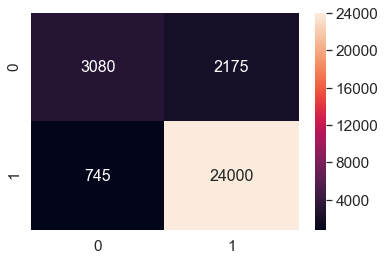

In [55]:
y_pred = clf_svm.predict(final_test_tf_idf)
print("\tPrecision: %1.3f" % precision_score(Y_test, y_pred))
print("\tRecall: %1.3f" % recall_score(Y_test, y_pred))
print("\tF1: %1.3f" % f1_score(Y_test, y_pred))
print("\tROC_AUC: %1.3f" % roc_auc_score(Y_test, y_pred))
df_cm = pd.DataFrame(confusion_matrix(Y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

#### Linear SVM on Tfidf using LinearSVC

In [56]:
# Linear kernel using LinearSVC
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.model_selection import GridSearchCV
parameters = {'C':[0.1, 1, 10]}
tscv = TimeSeriesSplit(n_splits=5)
lsvc = LinearSVC(penalty='l2',class_weight='balanced',dual=False)
clf_gs = GridSearchCV(lsvc, parameters, cv=tscv,scoring='roc_auc', n_jobs=-1)

LinearSVC(C=0.1, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
	Precision: 0.970
	Recall: 0.874
	F1: 0.919
	ROC_AUC: 0.873


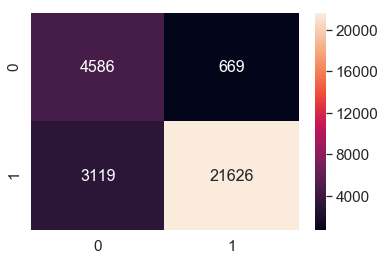

In [57]:
clf_gs.fit(final_train_tf_idf, Y_train)
print(clf_gs.best_estimator_)
y_pred = clf_gs.best_estimator_.predict(final_test_tf_idf)
print("\tPrecision: %1.3f" % precision_score(Y_test, y_pred))
print("\tRecall: %1.3f" % recall_score(Y_test, y_pred))
print("\tF1: %1.3f" % f1_score(Y_test, y_pred))
print("\tROC_AUC: %1.3f" % roc_auc_score(Y_test, y_pred))
df_cm = pd.DataFrame(confusion_matrix(Y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g');

x.add_row(["TFIDF", "Linear kernel using LinearSVC",clf_gs.best_params_, f1_score(Y_test, y_pred), roc_auc_score(Y_test, y_pred)])

#### Top 10 positive and negative features

In [58]:
# Print the best feature for each of the positive and negative classes

n=10
coefs = sorted(zip(clf_gs.best_estimator_.coef_[0], feat))
top = zip(coefs[:n], coefs[:-(n + 1):-1])
print("\t\t\tNegative\t\t\t\t\tPositive")
for (coef1, feat1), (coef2, feat2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef1, feat1, coef2, feat2))

			Negative					Positive
	-2.9926	exposur        				3.5974	kid            
	-2.1030	beagl          				2.9951	bouillon       
	-2.0584	maca           				2.7822	enchilada      
	-1.6721	thought        				2.7251	pass           
	-1.5921	brie           				2.6102	signatur       
	-1.5554	foodi          				2.1681	gnaw           
	-1.5519	know           				1.9393	guava          
	-1.5296	behavior       				1.9300	anytim         
	-1.4848	luscious       				1.8013	jiffi          
	-1.3714	versatil       				1.6621	work           


#### Linear SVM on Avg. W2V using SGDClassifier

In [59]:
# Linear kernel using SGDClassifier

clf = SGDClassifier(loss='hinge',penalty='l2',max_iter=1000, tol=1e-3, class_weight='balanced',random_state=0)
tscv = TimeSeriesSplit(n_splits=5)
clf_svm = CalibratedClassifierCV(base_estimator=clf, cv=tscv, method='sigmoid')
clf_svm.fit(sent_vectors_train, Y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=0, shuffle=True,
       tol=0.001, verbose=0, warm_start=False),
            cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
            method='sigmoid')

	Precision: 0.880
	Recall: 0.975
	F1: 0.925
	ROC_AUC: 0.674


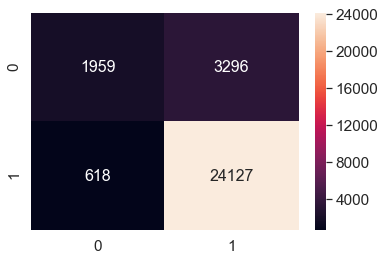

In [60]:
y_pred = clf_svm.predict(sent_vectors_test)
print("\tPrecision: %1.3f" % precision_score(Y_test, y_pred))
print("\tRecall: %1.3f" % recall_score(Y_test, y_pred))
print("\tF1: %1.3f" % f1_score(Y_test, y_pred))
print("\tROC_AUC: %1.3f" % roc_auc_score(Y_test, y_pred))
df_cm = pd.DataFrame(confusion_matrix(Y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
x.add_row(["Avg W2V", "Linear kernel using SGDClassifier",clf_svm.predict, f1_score(Y_test, y_pred), roc_auc_score(Y_test, y_pred)])

#### Linear SVM on Weighted Tfidf-W2V using SGDClassifier

In [61]:
# Linear kernel using SGDClassifier

clf = SGDClassifier(loss='hinge',penalty='l2',max_iter=1000, tol=1e-3, class_weight='balanced',random_state=0)
tscv = TimeSeriesSplit(n_splits=5)
clf_svm = CalibratedClassifierCV(base_estimator=clf, cv=tscv, method='sigmoid')
clf_svm.fit(tfidf_sent_vec_train, Y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=0, shuffle=True,
       tol=0.001, verbose=0, warm_start=False),
            cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
            method='sigmoid')

	Precision: 0.825
	Recall: 1.000
	F1: 0.904
	ROC_AUC: 0.500


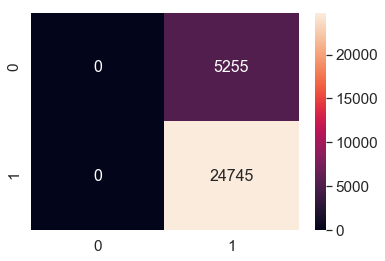

In [62]:
y_pred = clf_svm.predict(tfidf_sent_vec_test)
print("\tPrecision: %1.3f" % precision_score(Y_test, y_pred))
print("\tRecall: %1.3f" % recall_score(Y_test, y_pred))
print("\tF1: %1.3f" % f1_score(Y_test, y_pred))
print("\tROC_AUC: %1.3f" % roc_auc_score(Y_test, y_pred))
df_cm = pd.DataFrame(confusion_matrix(Y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
x.add_row(["tf-idf-W2V", "Linear kernel using SGDClassifier",clf_svm.predict, f1_score(Y_test, y_pred), roc_auc_score(Y_test, y_pred)])

### RBF SVM

#### RBF SVM on BagofWords

In [63]:
#data splitting for RBF kernel
y_train=final_sorted_time['Score'][0:13000]
y_cv=final_sorted_time['Score'][13000:16000]
y_test=final_sorted_time['Score'][16000:20000]

In [64]:

X_train=final_sorted_time['CleanedText'][0:13000]
X_cv=final_sorted_time['CleanedText'][13000:16000]
X_test=final_sorted_time['CleanedText'][16000:20000]

In [65]:
cnt_vec = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=300)
bow_train = cnt_vec.fit_transform(X_train)
bow_cv  = cnt_vec.transform(X_cv)
bow_test = cnt_vec.transform(X_test)


	Precision: 0.958
	Recall: 0.819
	F1: 0.883
	ROC_AUC: 0.789


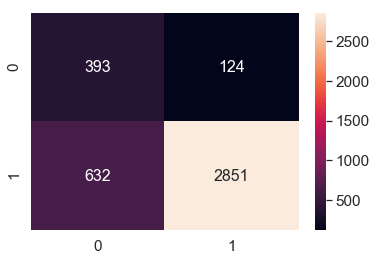

In [66]:
parameters = {'gamma':[10**-4, 10**-2, 10**0, 10**2, 10**4],
             'C':[10**-4, 10**-2, 10**0, 10**2, 10**4]}
tscv = TimeSeriesSplit(n_splits=5)
rbfsvc = SVC(kernel='rbf',class_weight='balanced')
clf_gs = GridSearchCV(rbfsvc, parameters, cv=tscv,scoring='roc_auc', n_jobs=-1)

clf_gs.fit(bow_train, y_train)

y_pred = clf_gs.best_estimator_.predict(bow_test)
print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
print("\tF1: %1.3f" % f1_score(y_test, y_pred))
print("\tROC_AUC: %1.3f" % roc_auc_score(y_test, y_pred))

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4) #for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

x.add_row(["BoW", "RBF SVM",clf_gs.best_params_, f1_score(y_test, y_pred), roc_auc_score(y_test, y_pred)])


 #### RBF SVM on TFIDF

In [67]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=300)
tf_train = tfidf_vec.fit_transform(X_train)
tf_cv  = tfidf_vec.transform(X_cv)
tf_test = tfidf_vec.transform(X_test)

	Precision: 0.939
	Recall: 0.934
	F1: 0.937
	ROC_AUC: 0.764


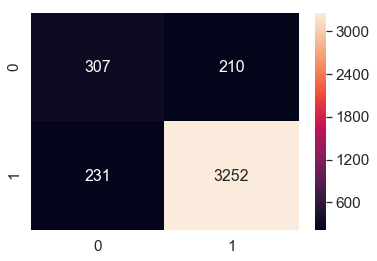

In [68]:
parameters = {'gamma':[10**-4, 10**-2, 10**0, 10**2, 10**4],
             'C':[10**-4, 10**-2, 10**0, 10**2, 10**4]}
tscv = TimeSeriesSplit(n_splits=5)
rbfsvc = SVC(kernel='rbf',class_weight='balanced')
clf_gs = GridSearchCV(rbfsvc, parameters, cv=tscv,scoring='roc_auc', n_jobs=-1)

clf_gs.fit(tf_train, y_train)

y_pred = clf_gs.best_estimator_.predict(tf_test)
print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
print("\tF1: %1.3f" % f1_score(y_test, y_pred))
print("\tROC_AUC: %1.3f" % roc_auc_score(y_test, y_pred))

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4) #for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

x.add_row(["Tfidf", "RBF SVM",clf_gs.best_params_, f1_score(y_test, y_pred), roc_auc_score(y_test, y_pred)])


#### RBF SVM on Avg W2V

In [69]:
avg_w2v = np.array(sent_vectors_train)

In [70]:
avg_w2v.shape

(49000, 50)

In [71]:

avgw2v_train = avg_w2v[0:13000]
avgw2v_cv = avg_w2v[13000:16000]
avgw2v_test = avg_w2v[16000:20000]

In [72]:
avgw2v_train.shape

(13000, 50)

In [73]:
y_train.shape

(13000,)

	Precision: 0.974
	Recall: 0.796
	F1: 0.876
	ROC_AUC: 0.825


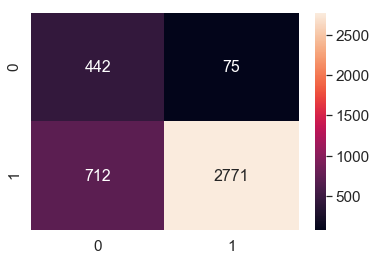

In [74]:
parameters = {'gamma':[10**-4, 10**-2, 10**0, 10**2, 10**4],
             'C':[10**-4, 10**-2, 10**0, 10**2, 10**4]}
tscv = TimeSeriesSplit(n_splits=5)
rbfsvc = SVC(kernel='rbf',class_weight='balanced')
clf_gs = GridSearchCV(rbfsvc, parameters, cv=tscv,scoring='roc_auc', n_jobs=-1)

clf_gs.fit(avgw2v_train, y_train)

y_pred = clf_gs.best_estimator_.predict(avgw2v_test)
print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
print("\tF1: %1.3f" % f1_score(y_test, y_pred))
print("\tROC_AUC: %1.3f" % roc_auc_score(y_test, y_pred))

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4) #for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

x.add_row(["Avg-W2V", "RBF SVM",clf_gs.best_params_, f1_score(y_test, y_pred), roc_auc_score(y_test, y_pred)])


#### RBF SVM on weighted tfidf-w2v

In [75]:
tfw2v_train.shape

(49000, 50)

In [76]:
tfrbf_train = tfw2v_train[0:13000]
tfrbf_cv = tfw2v_train[13000:16000]
tfrbf_test = tfw2v_train[16000:20000]

In [77]:
y_train.shape

(13000,)

	Precision: 0.871
	Recall: 1.000
	F1: 0.931
	ROC_AUC: 0.500


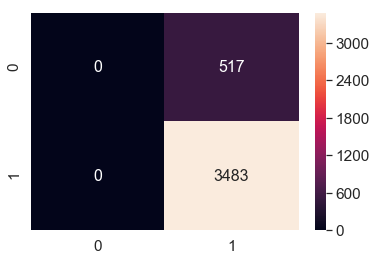

In [78]:
parameters = {'gamma':[10**-4, 10**-2, 10**0, 10**2, 10**4],
             'C':[10**-4, 10**-2, 10**0, 10**2, 10**4]}
tscv = TimeSeriesSplit(n_splits=5)
rbfsvc = SVC(kernel='rbf',class_weight='balanced')
clf_gs = GridSearchCV(rbfsvc, parameters, cv=tscv,scoring='roc_auc', n_jobs=-1)

clf_gs.fit(tfrbf_train, y_train)

y_pred = clf_gs.best_estimator_.predict(tfrbf_test)
print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
print("\tF1: %1.3f" % f1_score(y_test, y_pred))
print("\tROC_AUC: %1.3f" % roc_auc_score(y_test, y_pred))

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4) #for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

x.add_row(["tfidf-W2V", "RBF SVM",clf_gs.best_params_, f1_score(y_test, y_pred), roc_auc_score(y_test, y_pred)])

### Conclusion

In [81]:
from prettytable import PrettyTable

# Names of models
names= ['Linear SVM with BOW','Linear SVM with TFIDF', 'Linear SVM with AVG W2V','Linear SVM with TFIDF W2V',\
       'RBF Kernel SVM with BOW','RBF Kernel SVM with TFIDF','RBF Kernel SVM with AVG W2V','RBF Kernel SVM with TFIDF W2v']

optimal_alpha = [0.01, 1e-05, 0.01, 0.001,'Not Applicable','Not Applicable','Not Applicable','Not Applicable']
values_of_C=['Not Applicable','Not Applicable','Not Applicable','Not Applicable',1,1,10,1000]
gammas=['Not Applicable','Not Applicable','Not Applicable','Not Applicable',0.01,1,0.01,0.001]

test_value=[0.850, 0.873,0.674,0.500,0.789,0.764,0.825,0.500]
pen=['L2','L2','L2','L2', 'Not Applicable','Not Applicable','Not Applicable','Not Applicable']



numbering = [1,2,3,4,5,6,7,8]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Best Alpha",optimal_alpha)
ptable.add_column("Best C", values_of_C)
ptable.add_column("gamma",gammas)
#ptable.add_column("Training's AUC",training_value)
#ptable.add_column("CV's AUC",cv_value)
ptable.add_column("Testing's AUC",test_value)
ptable.add_column("Penalty",pen)

# Printing the Table
ptable.align = "c"
#from prettytable import MSWORD_FRIENDLY
#ptable.set_style(MSWORD_FRIENDLY)

print(ptable)

+-------+-------------------------------+----------------+----------------+----------------+---------------+----------------+
| S.NO. |             MODEL             |   Best Alpha   |     Best C     |     gamma      | Testing's AUC |    Penalty     |
+-------+-------------------------------+----------------+----------------+----------------+---------------+----------------+
|   1   |      Linear SVM with BOW      |      0.01      | Not Applicable | Not Applicable |      0.85     |       L2       |
|   2   |     Linear SVM with TFIDF     |     1e-05      | Not Applicable | Not Applicable |     0.873     |       L2       |
|   3   |    Linear SVM with AVG W2V    |      0.01      | Not Applicable | Not Applicable |     0.674     |       L2       |
|   4   |   Linear SVM with TFIDF W2V   |     0.001      | Not Applicable | Not Applicable |      0.5      |       L2       |
|   5   |    RBF Kernel SVM with BOW    | Not Applicable |       1        |      0.01      |     0.789     | Not Appli

#### From above table we can see that AUC value for Linear SVM with TFIDF is pretty well among all.